# <center>Household Power Consumption Prediction<center/>

### Description 
This notebook implements a an sequential model from Household Power Consumption Prediction. Model input are measurements of electric power consumption. Data was gathered from one household with a one-minute sampling rate over a period of almost 4 years.

#### Data Set Information:

The dataset contains 2075259 samples/measurements gathered between December 2006 and November 2010 (47 months).<br>
**NOTE**: 
> (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

> The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Data Attributes Information:** 

1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. global_active_power: household global minute-averaged active power (in kilowatt)

4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. <br>

#### Task : 
> Predict the power consumption together with upper and lower interval

### Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor

### Read data

In [2]:
data_path = "../Dataset/household_power_consumption_data.zip"
df = pd.read_csv(data_path, sep=';',parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'],index_col='dt')
df.drop(["Global_active_power","Global_reactive_power","Voltage","Global_intensity"],axis=1,inplace=True)

### Preprocess Data
Fill NaN values by average, extract features from timestamps & group the data

In [3]:
#fill nan values with column average
for j in range(0,3):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

df["consumption"] = df.iloc[:,:].sum(axis=1)
df.head()

,Sub_metering_1,Sub_metering_2,Sub_metering_3,consumption
dt,,,,
2006-12-16 17:24:00,0.0,1.0,17.0,18.0
2006-12-16 17:25:00,0.0,1.0,16.0,17.0
2006-12-16 17:26:00,0.0,2.0,17.0,19.0
2006-12-16 17:27:00,0.0,1.0,17.0,18.0
2006-12-16 17:28:00,0.0,1.0,17.0,18.0


In [4]:
#Extract features from timestamp 
def features_from_timestamp(t):
    h = t.hour
    year = t.year
    idx = np.searchsorted(list(range(3,25,3)),h,side='right')
    interval = np.arange(3,25,3)[idx]
    if  interval == 24 : interval = 0
    month = t.month
    season = (month in [11,12,1,2,3]) * 1 # 0: summer, 1:  winter
    return [h, t.day, t.dayofweek, month, interval, season, year]

col = ["hour", "day", "dayofweek", "month" ,"interval" ,"season","year"]

In [5]:
grouped = df["consumption"].groupby(pd.Grouper(freq='1h', base=0, label='right')).sum()
data = pd.DataFrame(grouped/60)

# Generate aditional features from timestamp then append to exixting data
additional_featues = pd.DataFrame(data = [features_from_timestamp(i) for i in data.index ],columns=col).set_index(data.index)
data = data.merge(additional_featues,on="dt")
data.sort_index(inplace=True) #make sure data is sorted by date
data.head()

,consumption,hour,day,dayofweek,month,interval,season,year
dt,,,,,,,,
2006-12-16 18:00:00,10.433333,18,16,5,12,21,1,2006
2006-12-16 19:00:00,23.583333,19,16,5,12,21,1,2006
2006-12-16 20:00:00,18.116667,20,16,5,12,21,1,2006
2006-12-16 21:00:00,16.783333,21,16,5,12,0,1,2006
2006-12-16 22:00:00,17.633333,22,16,5,12,0,1,2006


### Split data to train and test
Take one year as test sample (2010) and 3 years as trainning set (2006 - 2009)

In [6]:
#Split data to train and test
xtrain = data.loc["2006":"2010"]
ytrain = xtrain.pop("consumption")

xtest = data.loc["2010":]
ytest = xtest.pop("consumption")

### Define models & Train models
Define and set modes training paramaters

#### Use sklearn Gradient Boosting Regressor

In [7]:
LOWER_ALPHA = 0.10
UPPER_ALPHA = 0.90

N_ESTIMATORS = 100
MAX_DEPTH = 5

# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)


#Train Models
_ = lower_model.fit(xtrain, ytrain)
_ = mid_model.fit(xtrain, ytrain)
_ = upper_model.fit(xtrain, ytrain)

#### Use Catboost 

In [8]:
# N_ESTIMATORS = 100
# MAX_DEPTH = 5

# lower_model_catb = CatBoostRegressor(loss_function='Quantile:alpha=0.10', n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
# mid_model_catb = CatBoostRegressor(loss_function='Quantile:alpha=0.5', n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
# upper_model_catb = CatBoostRegressor(loss_function='Quantile:alpha=0.90', n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

# #Train Models
# lower_model_catb.fit(xtrain, ytrain,verbose =0)
# mid_model_catb.fit(xtrain, ytrain, verbose =0)
# upper_model_catb.fit(xtrain, ytrain, verbose =0)

### Predictions

In [9]:
predictions = pd.DataFrame(ytest)
predictions['lower'] = lower_model.predict(xtest)
predictions['mid'] = mid_model.predict(xtest)
predictions['upper'] = upper_model.predict(xtest)

assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

,consumption,lower,mid,upper
dt,,,,
2010-11-26 18:00:00,12.866667,0.237345,8.202809,17.179935
2010-11-26 19:00:00,0.000000,0.136176,8.352726,17.424431
2010-11-26 20:00:00,0.066667,0.166339,9.052072,20.621429
2010-11-26 21:00:00,1.066667,0.271902,10.455235,22.490176
2010-11-26 22:00:00,0.000000,0.170234,9.758888,20.693775


### Calculate model Errors

In [10]:
def calculate_error(predictions):
    predictions['absolute_error_lower'] = (predictions['lower'] - predictions["consumption"]).abs()
    predictions['absolute_error_upper'] = (predictions['upper'] - predictions["consumption"]).abs()
    
    predictions['absolute_error_interval'] = (predictions['absolute_error_lower'] + predictions['absolute_error_upper']) / 2
    predictions['absolute_error_mid'] = (predictions['mid'] - predictions["consumption"]).abs()
    
    predictions['in_bounds'] = predictions["consumption"].between(left=predictions['lower'], right=predictions['upper'])
    

In [11]:
calculate_error(predictions)
metrics = predictions[['absolute_error_lower', 'absolute_error_upper', 'absolute_error_interval', 'absolute_error_mid', 'in_bounds']].copy()
metrics.describe()

,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid
count,7919.000000,7919.000000,7919.000000,7919.000000
mean,8.152071,10.302705,9.227388,5.527419
std,9.427422,6.914497,4.543078,5.139411
min,0.000011,0.000295,1.701356,0.000813
25%,0.539495,5.379155,5.577411,1.912699
50%,3.848571,8.757068,9.213745,4.019383
75%,16.734875,15.099393,11.691505,7.827279
max,70.327440,38.356461,52.558623,50.813839


In [12]:
predictions.head()

,consumption,lower,mid,upper,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid,in_bounds
dt,,,,,,,,,
2010-01-01 00:00:00,18.316667,0.679920,9.683163,18.810314,17.636747,0.493647,9.065197,8.633504,True
2010-01-01 01:00:00,8.516667,0.679553,6.137491,18.431553,7.837114,9.914886,8.876000,2.379176,True
2010-01-01 02:00:00,1.450000,0.679553,2.831760,13.682513,0.770447,12.232513,6.501480,1.381760,True
2010-01-01 03:00:00,0.666667,0.679553,2.189347,10.581706,0.012886,9.915039,4.963963,1.522680,False
2010-01-01 04:00:00,1.383333,0.679553,1.576810,8.074886,0.703781,6.691553,3.697667,0.193476,True


### Plot model predictions

/usr/local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


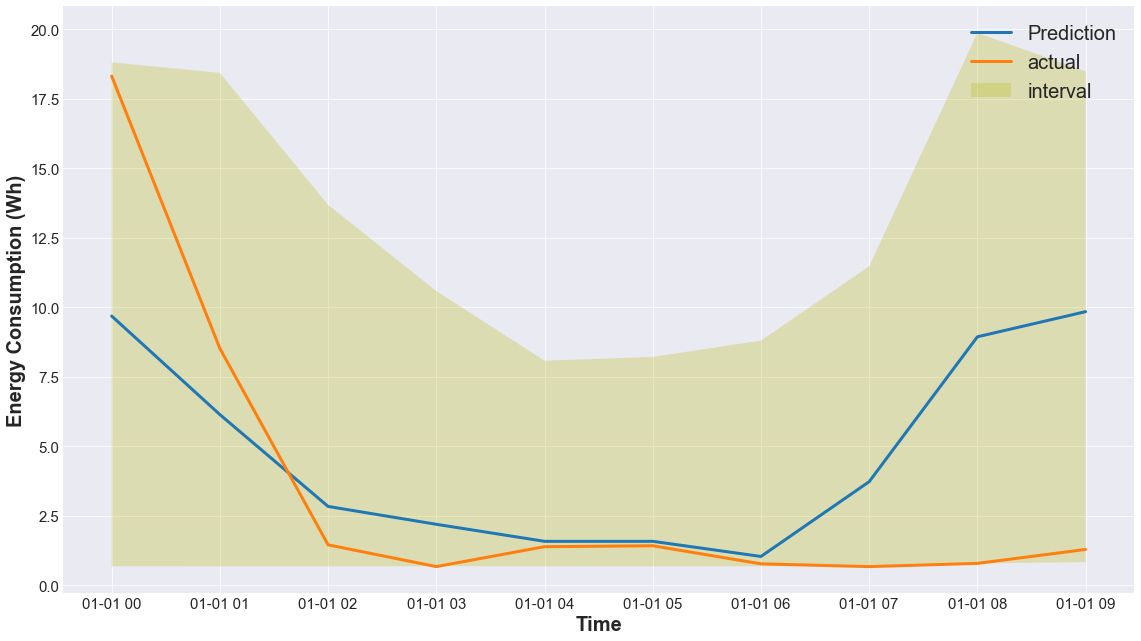

In [13]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(19.20,10.80))
# plt.plot(predictions.index[100:150], predictions.lower[100:150],label="Lower",linewidth=3)
plt.plot(predictions.index[:10], predictions.mid[:10],label="Prediction",linewidth=3)
# plt.plot(predictions.index[100:150], predictions.upper[100:150], label="Upper",linewidth=3)
plt.fill_between(predictions.index[:10], predictions.lower[:10], predictions.upper[:10],
                 alpha=0.3, facecolor=colors[8],label='interval')
plt.plot(predictions.index[:10], predictions.consumption[:10],label="actual",linewidth=3)
plt.legend(loc=0,prop={'size': 20})
plt.ylabel("Energy Consumption (Wh)",fontsize=20.0,fontweight="bold")
plt.xlabel("Time",fontsize=20.0,fontweight="bold")
plt.tick_params(labelsize=15)
plt.show()

In [14]:
metrics["in_bounds"].value_counts(normalize= True)

True     0.80149
False    0.19851
Name: in_bounds, dtype: float64

### Exploratory Data Analysis (optional)

In [15]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(df)
# profile.to_file("report.html")
# profile

In [16]:
# df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum')
# #df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red')
# plt.tight_layout()
# plt.show()

### <center> Predictions of intervals with LSTM <center/>